# Bitcoin Price Predictor for Data Analytics MSc Project

#### Importing necessary Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
# if using google colob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data Loading and Cleaning

In [5]:
data_dir = "../data/"

In [ ]:
btc_prices = pd.read_csv(data_dir+"BTC-USD.csv")
btc_prices.columns = [col.lower() for col in btc_prices.columns]
btc_prices["date"] = pd.to_datetime(btc_prices["date"])

In [ ]:
btc_prices

,date,open,high,low,close,adj close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3223,2023-07-15,30331.783203,30407.781250,30263.462891,30295.806641,30295.806641,8011667756
3224,2023-07-16,30297.472656,30437.560547,30089.669922,30249.132813,30249.132813,8516564470
3225,2023-07-17,30249.626953,30336.400391,29685.783203,30145.888672,30145.888672,13240156074
3226,2023-07-18,30147.070313,30233.656250,29556.427734,29856.562500,29856.562500,13138897269


<AxesSubplot:>

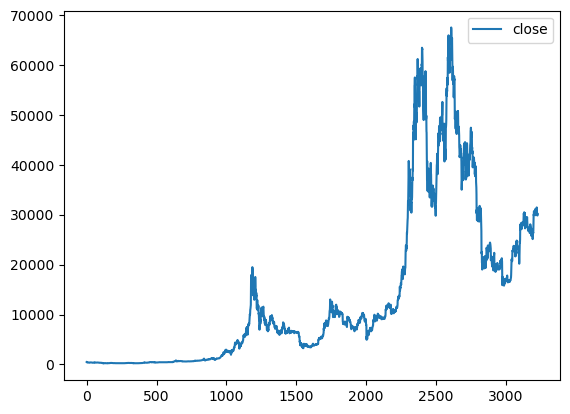

In [ ]:
btc_prices.plot.line(y="close", use_index=True)

In [ ]:
# This is a big file so took a while to load

column_names = ["date", "text"]
bitcoin_tweets = pd.read_csv(data_dir + "Bitcoin_tweets.csv", usecols=column_names, lineterminator="\n")

In [ ]:
bitcoin_tweets

,date,text
0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
1,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
2,2021-02-10 23:54:48,"Guys evening, I have read this article about B..."
3,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...
4,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...
...,...,...
4689349,2023-01-06 17:46:35,"Bitcoin squeeze is SUPER TIGHT, which way will..."
4689350,2023-01-06 17:46:29,Closed #BTC short at 16725. Missed my long pla...
4689351,2023-01-06 17:46:22,#Ethereum price update: \n\n#ETH $1263.59 USD\...
4689352,2023-01-06 17:46:20,1₿ = $16814.7 -0.07%🔻\n\nDetails:\nChange: 🔻-1...


In [ ]:
# Identify and remove rows with invalid date values
bitcoin_tweets = bitcoin_tweets[bitcoin_tweets["date"].str.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}')]

# Convert the datetime column to datetime type
bitcoin_tweets["date"] = pd.to_datetime(bitcoin_tweets["date"])

# Extract the date part and overwrite the original column
bitcoin_tweets["date"] = bitcoin_tweets["date"].dt.date
bitcoin_tweets["date"] = pd.to_datetime(bitcoin_tweets["date"])

C:\Users\benga\AppData\Local\Temp\ipykernel_27912\62376477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_tweets["date"] = pd.to_datetime(bitcoin_tweets["date"])
C:\Users\benga\AppData\Local\Temp\ipykernel_27912\62376477.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_tweets["date"] = bitcoin_tweets["date"].dt.date


In [ ]:
bitcoin_tweets

,date,text
0,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...
1,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""..."
2,2021-02-10,"Guys evening, I have read this article about B..."
3,2021-02-10,$BTC A big chance in a billion! Price: \487264...
4,2021-02-10,This network is secured by 9 508 nodes as of t...
...,...,...
4689349,2023-01-06,"Bitcoin squeeze is SUPER TIGHT, which way will..."
4689350,2023-01-06,Closed #BTC short at 16725. Missed my long pla...
4689351,2023-01-06,#Ethereum price update: \n\n#ETH $1263.59 USD\...
4689352,2023-01-06,1₿ = $16814.7 -0.07%🔻\n\nDetails:\nChange: 🔻-1...


In [ ]:
# to keep the first occurrence and remove duplicates
bitcoin_tweets = bitcoin_tweets.drop_duplicates(subset=["date"])
bitcoin_tweets

,date,text
0,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...
3526,2021-02-09,⬇️ Seller alert: 10 $BTC sold into the bid @ 4...
7876,2021-02-08,Crypto Space Keeps Making History 💥\n\n#Bitcoi...
13523,2021-02-07,Pretty sure you're supposed to be getting it t...
16553,2021-02-06,@timevalueofbtc @CandiceOnAir Fair point. Many...
...,...,...
4622268,2022-12-24,🎇 This is an opportunity!\n\n💎DIAMOND\n🪙GOLD\n...
4628467,2023-01-09,BECAUSE IT'S A LIFE\nCHANGING\nOPPORTUNITY FOR...
4657960,2023-01-08,#Bitcoin Last Price $17110 #BTC 🚀\nWeekly Indi...
4662226,2023-01-07,#Ethereum price update: \n\n#ETH $1263.5 USD\n...


In [ ]:
# Merge DataFrames on the 'date' column
merged_df = pd.merge(btc_prices, bitcoin_tweets, on='date', how='left')
merged_df

,date,open,high,low,close,adj close,volume,text
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,NaN
...,...,...,...,...,...,...,...,...
3223,2023-07-15,30331.783203,30407.781250,30263.462891,30295.806641,30295.806641,8011667756,NaN
3224,2023-07-16,30297.472656,30437.560547,30089.669922,30249.132813,30249.132813,8516564470,NaN
3225,2023-07-17,30249.626953,30336.400391,29685.783203,30145.888672,30145.888672,13240156074,NaN
3226,2023-07-18,30147.070313,30233.656250,29556.427734,29856.562500,29856.562500,13138897269,NaN


In [ ]:
# Sort the DataFrame by the 'date' column in ascending order
merged_df = merged_df.sort_values(by='date', ascending=True)

In [ ]:
# Filter the DataFrame for entries between 05/02/2021 and 09/01/2023
start_date = '2021-02-05'
end_date = '2023-01-09'

filtered_df = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] <= end_date)]

In [ ]:
filtered_df

,date,open,high,low,close,adj close,volume,text
2333,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,Grayscale Bitcoin Trust grew by $15.7b in 2020...
2334,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,@timevalueofbtc @CandiceOnAir Fair point. Many...
2335,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,Pretty sure you're supposed to be getting it t...
2336,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,Crypto Space Keeps Making History 💥\n\n#Bitcoi...
2337,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,⬇️ Seller alert: 10 $BTC sold into the bid @ 4...
...,...,...,...,...,...,...,...,...
3032,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,13692758566,NaN
3033,2023-01-06,16836.472656,16991.994141,16716.421875,16951.968750,16951.968750,14413662913,#Ethereum price update: \n\n#ETH $1269.56 USD\...
3034,2023-01-07,16952.117188,16975.017578,16914.191406,16955.078125,16955.078125,7714767174,#Ethereum price update: \n\n#ETH $1263.5 USD\n...
3035,2023-01-08,16954.146484,17091.144531,16924.050781,17091.144531,17091.144531,9768827914,#Bitcoin Last Price $17110 #BTC 🚀\nWeekly Indi...


In [ ]:
# save filtered_df to a csv file
filtered_df.to_csv(data_dir + "merged_filtered_df.csv", index=False)

#### Sentiment Analysis

In [ ]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(x)["neg"] if not pd.isna(x) else np.nan)
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(x)["neu"] if not pd.isna(x) else np.nan)
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(x)["pos"] if not pd.isna(x) else np.nan)

In [ ]:
# Apply the function to the DataFrame
compute_vader_scores(filtered_df, label="text")

C:\Users\benga\AppData\Local\Temp\ipykernel_27912\3625864597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(x)["neg"] if not pd.isna(x) else np.nan)
C:\Users\benga\AppData\Local\Temp\ipykernel_27912\3625864597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(x)["neu"] if not pd.isna(x) else np.nan)
C:\Users\benga\AppData\Local\Temp\ipykernel_27912\3625864597.py:5: SettingWi

In [ ]:
filtered_df

,date,open,high,low,close,adj close,volume,text,vader_neg,vader_neu,vader_pos
2333,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,Grayscale Bitcoin Trust grew by $15.7b in 2020...,0.000,0.798,0.202
2334,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,@timevalueofbtc @CandiceOnAir Fair point. Many...,0.000,0.825,0.175
2335,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,Pretty sure you're supposed to be getting it t...,0.098,0.671,0.231
2336,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,Crypto Space Keeps Making History 💥\n\n#Bitcoi...,0.000,1.000,0.000
2337,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,⬇️ Seller alert: 10 $BTC sold into the bid @ 4...,0.000,0.855,0.145
...,...,...,...,...,...,...,...,...,...,...,...
3032,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,13692758566,NaN,NaN,NaN,NaN
3033,2023-01-06,16836.472656,16991.994141,16716.421875,16951.968750,16951.968750,14413662913,#Ethereum price update: \n\n#ETH $1269.56 USD\...,0.000,1.000,0.000
3034,2023-01-07,16952.117188,16975.017578,16914.191406,16955.078125,16955.078125,7714767174,#Ethereum price update: \n\n#ETH $1263.5 USD\n...,0.000,1.000,0.000
3035,2023-01-08,16954.146484,17091.144531,16924.050781,17091.144531,17091.144531,9768827914,#Bitcoin Last Price $17110 #BTC 🚀\nWeekly Indi...,0.000,1.000,0.000


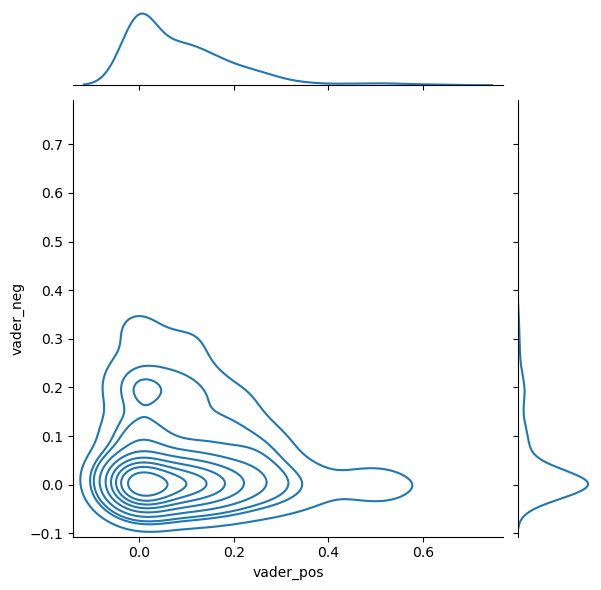

In [ ]:
sns.jointplot(data=filtered_df, x='vader_pos', y='vader_neg', kind="kde")

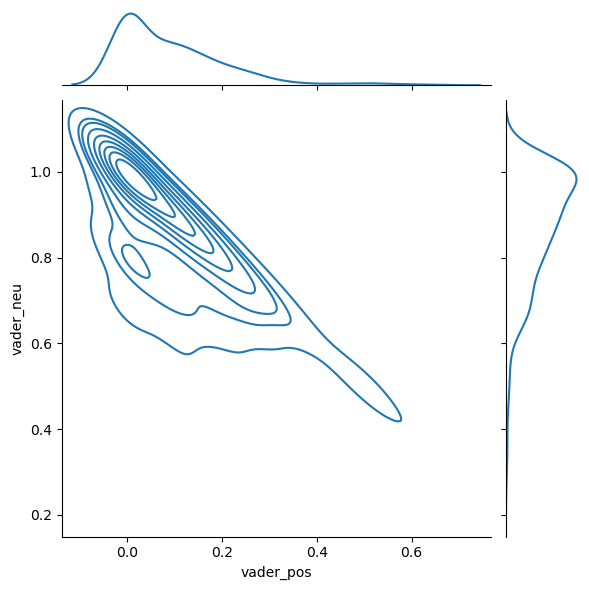

In [ ]:
sns.jointplot(data=filtered_df, x='vader_pos', y='vader_neu', kind="kde")

In [ ]:
class0=[]
for index, row in filtered_df.iterrows():
    if row['vader_neg']>0:
        class0+=[0]
    elif row['vader_pos']>0:
        class0+=[2]
    else:
        class0+=[1]

In [ ]:
filtered_df["sentiment"] = class0

C:\Users\benga\AppData\Local\Temp\ipykernel_27912\620292592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["sentiment"] = class0


In [ ]:
filtered_df

,date,open,high,low,close,adj close,volume,text,vader_neg,vader_neu,vader_pos,sentiment
2333,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,Grayscale Bitcoin Trust grew by $15.7b in 2020...,0.000,0.798,0.202,2
2334,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,@timevalueofbtc @CandiceOnAir Fair point. Many...,0.000,0.825,0.175,2
2335,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,Pretty sure you're supposed to be getting it t...,0.098,0.671,0.231,0
2336,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,Crypto Space Keeps Making History 💥\n\n#Bitcoi...,0.000,1.000,0.000,1
2337,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,⬇️ Seller alert: 10 $BTC sold into the bid @ 4...,0.000,0.855,0.145,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3032,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,13692758566,NaN,NaN,NaN,NaN,1
3033,2023-01-06,16836.472656,16991.994141,16716.421875,16951.968750,16951.968750,14413662913,#Ethereum price update: \n\n#ETH $1269.56 USD\...,0.000,1.000,0.000,1
3034,2023-01-07,16952.117188,16975.017578,16914.191406,16955.078125,16955.078125,7714767174,#Ethereum price update: \n\n#ETH $1263.5 USD\n...,0.000,1.000,0.000,1
3035,2023-01-08,16954.146484,17091.144531,16924.050781,17091.144531,17091.144531,9768827914,#Bitcoin Last Price $17110 #BTC 🚀\nWeekly Indi...,0.000,1.000,0.000,1


In [ ]:
# filtered_df.to_csv(data_dir + "filterd_sentiment_score_df.csv", index=False)

In [ ]:
# making date the index
filtered_df.index = filtered_df.pop("date")

In [ ]:
filtered_df

,open,high,low,close,adj close,volume,text,vader_neg,vader_neu,vader_pos,sentiment
date,,,,,,,,,,,
2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,Grayscale Bitcoin Trust grew by $15.7b in 2020...,0.000,0.798,0.202,2
2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,@timevalueofbtc @CandiceOnAir Fair point. Many...,0.000,0.825,0.175,2
2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,Pretty sure you're supposed to be getting it t...,0.098,0.671,0.231,0
2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,Crypto Space Keeps Making History 💥\n\n#Bitcoi...,0.000,1.000,0.000,1
2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,⬇️ Seller alert: 10 $BTC sold into the bid @ 4...,0.000,0.855,0.145,2
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,13692758566,NaN,NaN,NaN,NaN,1
2023-01-06,16836.472656,16991.994141,16716.421875,16951.968750,16951.968750,14413662913,#Ethereum price update: \n\n#ETH $1269.56 USD\...,0.000,1.000,0.000,1
2023-01-07,16952.117188,16975.017578,16914.191406,16955.078125,16955.078125,7714767174,#Ethereum price update: \n\n#ETH $1263.5 USD\n...,0.000,1.000,0.000,1


<AxesSubplot:>

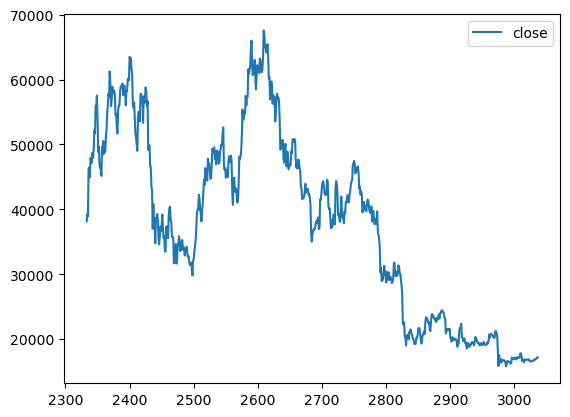

In [ ]:
filtered_df.plot.line(y="close", use_index=True)

#### Price Prediction

In [ ]:
import numpy as np
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(filtered_df[["close", "sentiment"]],
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,54529.144531,54738.945313,52774.265625,51704.160156
1,2021-03-26,54738.945313,52774.265625,51704.160156,55137.312500
2,2021-03-27,52774.265625,51704.160156,55137.312500,55973.511719
3,2021-03-28,51704.160156,55137.312500,55973.511719,55950.746094
4,2021-03-29,55137.312500,55973.511719,55950.746094,57750.199219
...,...,...,...,...,...
359,2022-03-19,41143.929688,40951.378906,41801.156250,42190.652344
360,2022-03-20,40951.378906,41801.156250,42190.652344,41247.824219
361,2022-03-21,41801.156250,42190.652344,41247.824219,41077.996094
362,2022-03-22,42190.652344,41247.824219,41077.996094,42358.808594


In [ ]:
# adding sentiment scores
windowed_df = pd.merge(windowed_df, pd.DataFrame({"sentiment": filtered_df["sentiment"].values}), left_index=True, right_index=True, how='left')

# changing postion of sentiment score column
windowed_df = windowed_df[["Target Date", "Target-3", "Target-2", "Target-1", "sentiment", "Target"]]
windowed_df

,Target Date,Target-3,Target-2,Target-1,sentiment,Target
0,2021-03-25,54529.144531,54738.945313,52774.265625,2,51704.160156
1,2021-03-26,54738.945313,52774.265625,51704.160156,2,55137.312500
2,2021-03-27,52774.265625,51704.160156,55137.312500,0,55973.511719
3,2021-03-28,51704.160156,55137.312500,55973.511719,1,55950.746094
4,2021-03-29,55137.312500,55973.511719,55950.746094,2,57750.199219
...,...,...,...,...,...,...
359,2022-03-19,41143.929688,40951.378906,41801.156250,1,42190.652344
360,2022-03-20,40951.378906,41801.156250,42190.652344,1,41247.824219
361,2022-03-21,41801.156250,42190.652344,41247.824219,1,41077.996094
362,2022-03-22,42190.652344,41247.824219,41077.996094,1,42358.808594


In [ ]:
# windowed_df.to_csv(data_dir+"windowed_df.csv", index=False)

In [6]:
windowed_df = pd.read_csv(data_dir + "windowed_df.csv")

In [4]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((364,), (364, 4, 1), (364,))

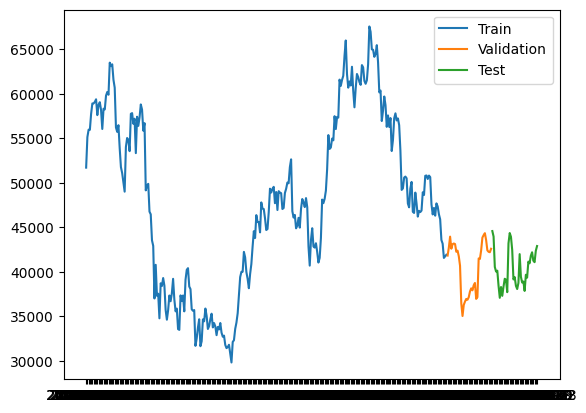

In [5]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [6]:
model = Sequential([layers.Input((4, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25)

Epoch 1/25
10/10 [==============================] - 8s 60ms/step - loss: 2416433920.0000 - mean_absolute_error: 48209.1797 - val_loss: 1649780096.0000 - val_mean_absolute_error: 40519.4375
Epoch 2/25
10/10 [==============================] - 0s 8ms/step - loss: 2416370944.0000 - mean_absolute_error: 48208.5156 - val_loss: 1649716992.0000 - val_mean_absolute_error: 40518.6602
Epoch 3/25
10/10 [==============================] - 0s 8ms/step - loss: 2416282880.0000 - mean_absolute_error: 48207.6016 - val_loss: 1649623936.0000 - val_mean_absolute_error: 40517.5156
Epoch 4/25
10/10 [==============================] - 0s 9ms/step - loss: 2416155904.0000 - mean_absolute_error: 48206.2891 - val_loss: 1649484288.0000 - val_mean_absolute_error: 40515.7852
Epoch 5/25
10/10 [==============================] - 0s 8ms/step - loss: 2415946752.0000 - mean_absolute_error: 48204.1094 - val_loss: 1649253888.0000 - val_mean_absolute_error: 40512.9414
Epoch 6/25
10/10 [==============================] - 0s 9ms/

10/10 [==============================] - 0s 2ms/step


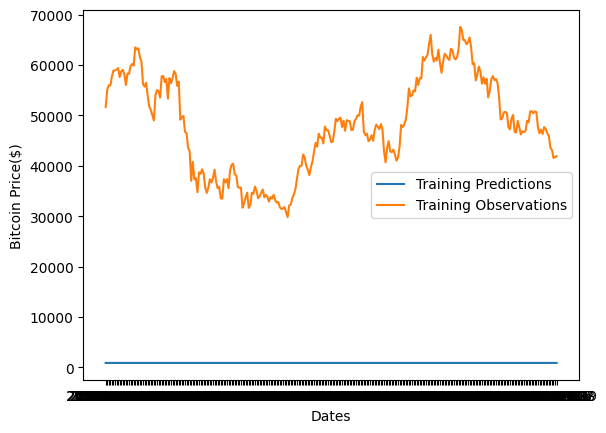

In [22]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.xlabel("Dates")
plt.ylabel("Bitcoin Price($)")
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 6ms/step


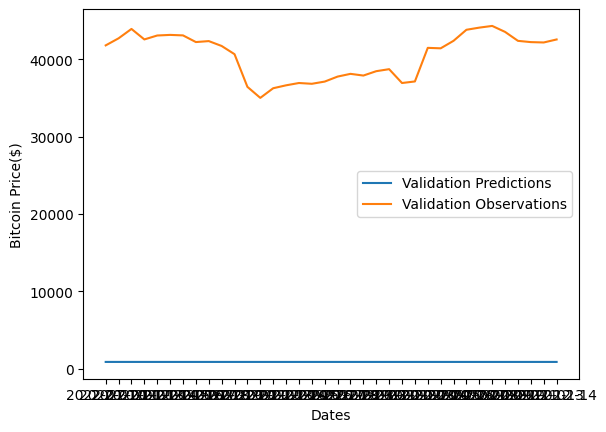

In [21]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xlabel("Dates")
plt.ylabel("Bitcoin Price($)")
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 6ms/step


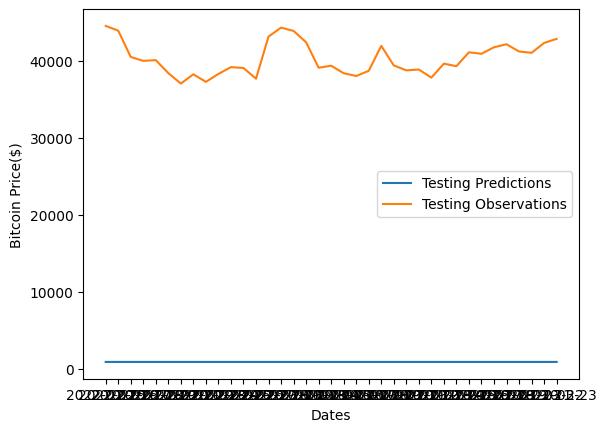

In [20]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xlabel("Dates")
plt.ylabel("Bitcoin Price($)")
plt.legend(['Testing Predictions', 'Testing Observations'])

In [14]:
from matplotlib.dates import DateFormatter, DayLocator

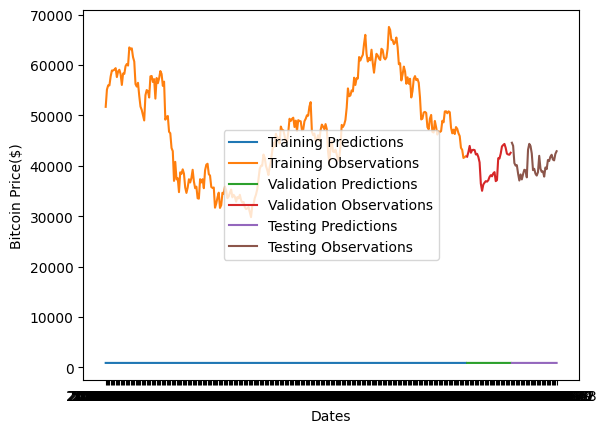

In [19]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xlabel("Dates")
plt.ylabel("Bitcoin Price($)")

plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])